In [1]:
from pysam import VariantFile

from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from upsetplot import UpSet, plot

In [2]:
# Helper functions

def sign(x):
    return "-" if x<0 else ""


def tolog100(x):
    """Sign aware conversion of size to have log100 behavior on the x axis"""
    if x>0:
        return np.log(x)/np.log(100)
    else:
        return - np.log(-x)/np.log(100)

    
def xaxis_format_func(value, tick_number):
    """The two args are the value and tick position
        In order to show sizes in pb, kb and Mb
    """
    if value == 0:
        return "0"
    elif np.abs(value) == 1:
        return "{0}100 bp".format(sign(value))
    elif np.abs(value) == 2:
        return "{0}10 kb".format(sign(value))
    elif np.abs(value) == 3:
        return "{0}1 Mb".format(sign(value))
     
        
def detected_by(idlist):
    """
    Name of the tool/technology according to the jasmine IDlist info field
    """
    tools = []
    idlist_str="-".join(idlist)
    if "svim" in idlist_str:
        tools.append("ONT")
    if "HiFi" in idlist_str:
        tools.append("HiFi")
    if "CLR" in idlist_str:
        tools.append("CLR")    
    if 'Manta' in idlist_str:
        tools.append("illumina")
    if "paftools" in idlist_str:
        tools.append("assembly")
    return tools


# Helper function to read a vcf file

def quality_at_least(rec, qual=0):
    if qual == 0:
        return True
    if rec.qual is None:
        return True
    if rec.qual > qual:
        return True
    return False

def re_at_least(rec, re_cutoff=0):
    if "RE" not in rec.info:
        return True
    if rec.info["RE"] > re_cutoff:
        return True
    return False

def read_depth_at_most(rec, rd_cutoff=-1):
    if rd_cutoff == -1 :
        return True
    maxrd = 0 
    for s in rec.samples:
        if "RD" in rec.samples[s]:
            maxrd = max(maxrd, rec.samples[s]['DP'])
    if maxrd <= rd_cutoff:
        return True
    return False

def on_chrom(rec):
    if "NKL" in rec.chrom:
        return False
    else:
        return True

def svlen(rec):
    svtype= get_svtype(rec.info['SVTYPE'])
    if svtype == "INS":            
        if type(rec.info['SVLEN']) == tuple:
            svlen = rec.info['SVLEN'][0]
        else:
            svlen = rec.info['SVLEN']
    else:
        svlen = rec.rlen
    return svlen
    
def get_svtype(svtype_info):
    if "INS" in svtype_info or 'DUP' in svtype_info:
        return svtype_info.split(":")[0]
    else:
        return svtype_info

def read_vcf(vcffile, qual=0, rd_cutoff=-1, re_cutoff=0,
             variant=False, onlychrom=False, svtype=None, 
             filter=False):
    vcf_in = VariantFile(vcffile)
    records = []
    for rec in vcf_in:
        if (quality_at_least(rec, qual) and 
            read_depth_at_most(rec, rd_cutoff) and
            re_at_least(rec, re_cutoff) and
            (not variant or is_variant(rec)) and
            (not onlychrom or on_chrom(rec)) and
            (not filter or "PASS" in rec.filter) and
            (svtype is None or rec.info['SVTYPE']==svtype)):
            records.append(rec)
    return records

def sv_stats(variants):
    "Count the number of variants according to type"
    sv_counter = Counter()
    for v in variants:
        svtype = v.info['SVTYPE']
        sv_counter[svtype] += 1
    df = pd.DataFrame.from_dict(sv_counter, orient='index').reset_index()
    df = df.rename(columns={'index':'svtype', 0:'count'})
    return df


def tool_concordance(vcf_records, tools, bionano_ids = []):
    """
    Construct a upset-compliant pandas dataframe
      boolean rows, one raow per variant, specifying of a 
      tool has detected this variant according to jasmine IDLIST
    """
    status = []
    for sv in vcf_records:
        counter = list(map(lambda x: x in detected_by(sv.info['IDLIST']), tools))
        counter.append(sv.id in bionano_ids)
        if len(bionano_ids):
            counter.append(sv.id)
        status.append(counter)
    if len(bionano_ids):
        all_tools = tools+["bionano"]
    else:
        all_tools = tools
    df = pd.DataFrame.from_records(status,columns=all_tools+["id"])
    df = df.set_index(all_tools)
    return df

In [7]:
vcf_file="testdata/test.vcf.gz"
tools = ['HiFi', 'CLR', 'ONT', 'illumina', 'assembly']

In [10]:
vcf_records =  read_vcf(vcf_file, onlychrom=True, filter=True)
sv_stats(vcf_records)

,svtype,count
0,INS,243
1,DEL,188


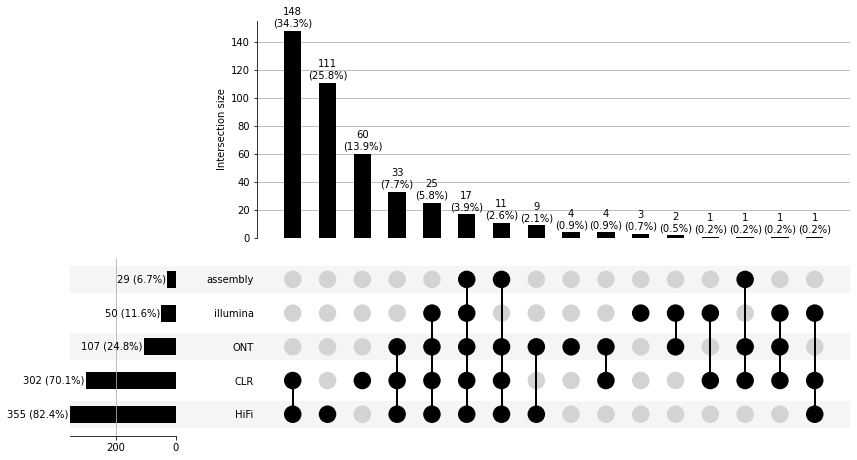

In [11]:
df = tool_concordance(vcf_records, tools)
upset = UpSet(df, subset_size='count', sort_by="cardinality", show_counts='%d',  show_percentages=True, element_size=50, totals_plot_elements =3)
axes = upset.plot()

In [12]:
svtype_records = defaultdict(list)
for sv in vcf_records:
    svtype_records[sv.info['SVTYPE']].append(sv)

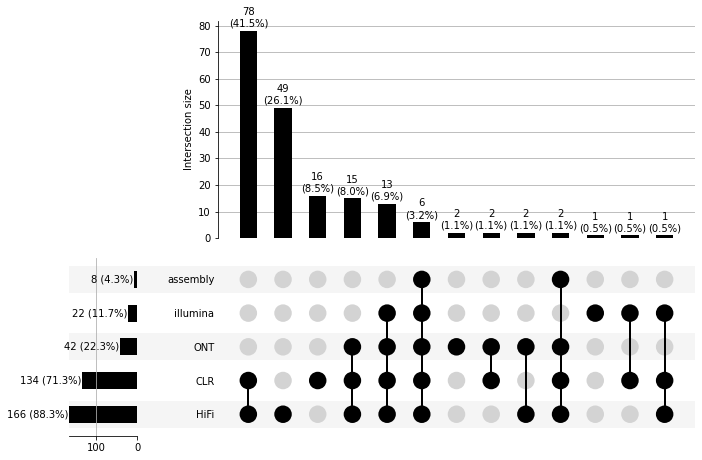

In [13]:
df = tool_concordance(svtype_records['DEL'], tools)
upset = UpSet(df,subset_size='count',sort_by="cardinality", show_counts='%d',   show_percentages=True, element_size=50)
axes = upset.plot()

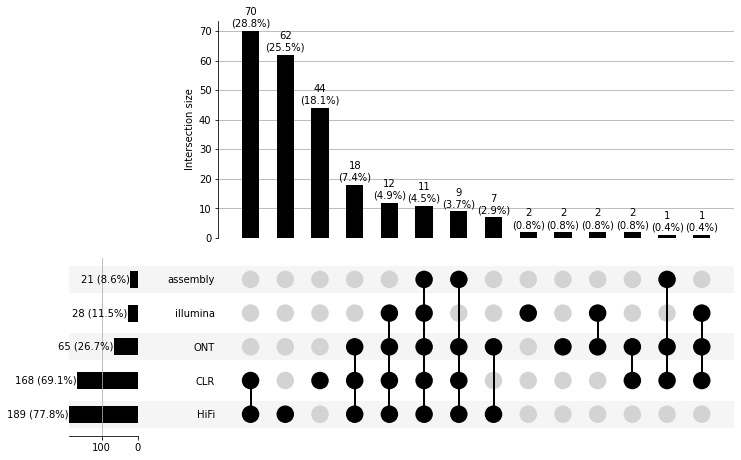

In [14]:
df = tool_concordance(svtype_records['INS'], tools)
upset = UpSet(df, subset_size='count', sort_by="cardinality", show_counts='%d',  show_percentages=True, element_size=50)
axes = upset.plot()